# Notebook para o PAN - Atribuição Autoral - 2018

In [5]:
%matplotlib inline
#python basic libs
from __future__ import print_function

from tempfile import mkdtemp
from shutil import rmtree
import os;
from os.path import join as pathjoin;

import re;
import glob;
import json;
import codecs;
from collections import defaultdict, Counter;
import pprint;

from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import random;
np.set_printoptions(precision=4)

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#preprocessing and transformation
from sklearn.preprocessing import normalize, MaxAbsScaler, MinMaxScaler;
from sklearn.preprocessing import LabelBinarizer;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;
from scipy.spatial.distance import cosine;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.linear_model import LogisticRegression


#
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;


In [6]:
import seaborn as sns;
#sns.set(color_codes=True);
from pandas.plotting import scatter_matrix

In [7]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
print("seaborn", sns.__version__)

Darwin-17.5.0-x86_64-i386-64bit
NumPy 1.14.2
SciPy 1.0.1
Scikit-Learn 0.19.1
seaborn 0.8.1


### paths configuration

In [8]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [9]:
def readCollectionsOfProblems(path):
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    with open(infocollection, 'r') as f:
        problems  = [
            {
                'problem': attrib['problem-name'],
                'language': attrib['language'],
                'encoding': attrib['encoding'],
            }
            for attrib in json.load(f)
            
        ]
    return problems;

In [10]:
problems = readCollectionsOfProblems(inputDir);

In [11]:
problems[0]

{'encoding': u'UTF-8', 'language': u'en', 'problem': u'problem00001'}

In [12]:
def readProblem(path, problem):
    # Reading information about the problem
    infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
    candidates = []
    with open(infoproblem, 'r') as f:
        fj = json.load(f)
        unk_folder = fj['unknown-folder']
        for attrib in fj['candidate-authors']:
            candidates.append(attrib['author-name'])
    return unk_folder, candidates;

In [13]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(pathjoin(path,label,'*.txt'))
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label, os.path.basename(v)))
        f.close()
    return texts

In [14]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [15]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [16]:
#*******************************************************************************************************
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder


def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints   = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall,accuracy


In [17]:
def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall,accuracy =  eval_measures(gt,pred)
    return f1, precision, recall, accuracy

In [18]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        """ Mock method. Does nothing.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        self
        """
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

In [19]:
def string_hashcode(s):
    h = 0
    for c in s:
        h = (31 * h + ord(c)) & 0xFFFFFFFF
    return ((h + 0x80000000) & 0xFFFFFFFF) - 0x80000000

In [20]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class EmbeddingTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, window=5, norm='l1', random_state=42):
        self.window = window;
        self.norm = norm;
        self.random_state =random_state;
        
        
    def doc2matrix(self,doc,vocab):
        arr = [doc[i:i+self.window] for i in range(len(doc)-self.window+1)];
        values = np.zeros((len(arr), len(vocab)));
        keys = [];

        for i,d in enumerate(arr):
            keys.append(d[self.window-1]);
            v = d[:(self.window-2)];
            for vv in v:
                if vv in vocab:
                    values[i,vocab[vv]]+=1;

        return values, keys;
    
    def getmemory(self, d):
        if memory == None:
            memory = {};
        
        h =string_hashcode(d);
        if h in memory:
            return memory[h]['k'],memory[h]['v'];
        
        k,v = self.doc2matrix(d,self.vocabulary_);
        memory[h]={'k':k,'v':v};
        return k,v;
        
    
    def matrix2Embedding(self,X,Y):
        clf =LogisticRegression(random_state=self.random_state)
        clf.fit(normalize(X,norm=self.norm,axis=0),Y);
        return dict(zip(clf.classes_,clf.coef_));
    
    def embeddingDistance(self,emb1,emb2):
        distance = 0;
        for c in emb1:
            if c in emb2:
                distance += 1-cosine(emb1[c], emb2[c]);
            else:
                distance += 1;
        return distance;

    def transform(self, X, y=None):
        result = np.zeros((len(X), len(self.embeddings_.keys())));
        for i,x in enumerate(X):
            m,k = self.getmemory(x);
            emb = self.matrix2Embedding(m,k);
            for j,class_ in enumerate(self.embeddings_):
                result[i,j] = self.embeddingDistance(emb, self.embeddings_[class_]);
        return result;

    
    def fit(self, X, y=None):
        self.vocabulary_ = {c:i for i,c in enumerate(set(list(''.join(X))))}
        
        #creating author profile
        profile = defaultdict(unicode);
        for text, label in zip(X,y):
            profile[label]+=text;
        
        self.embeddings_={};
        for class_,p in profile.items():
            v,e = self.getmemory(p);
            self.embeddings_ = {class_:self.matrix2Embedding(v,e)};
        
        return self

    def fit_transform(self, X, y=None):
        self.fit(X,y);
        return self.transform(X=X, y=y)

In [21]:
def doc2matrix(doc,vocab, window):
    arr = [doc[i:i+window] for i in range(len(doc)-window+1)];
    values = np.zeros((len(arr), len(vocab)));
    keys = [];

    for i,d in enumerate(arr):
        keys.append(d[window-1]);
        v = d[:(window-2)];
        for vv in v:
            if vv in vocab:
                values[i,vocab[vv]]+=1;

    return values, keys;

In [22]:
def matrix2Embedding(X,Y):
    clf =LogisticRegression(random_state=42)
    clf.fit(normalize(X,norm='l1',axis=0),Y);
    return dict(zip(clf.classes_,clf.coef_));

In [158]:
problem = problems[5]

In [159]:
print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']))
train_docs, train_labels, _   = zip(*problem['candidates'])
problem['training_docs_size'] = len(train_docs);
test_docs, _, test_filename   = zip(*problem['unknown'])


Problem: problem00006,  language: it, 


In [160]:
#code from baseline
gt = {}
with open(pathjoin(inputDir, problem['problem'], 'ground-truth.json'), 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']
test_docs, _, test_filename = zip(*problem['unknown'])
test_labels = [gt[v] for v in test_filename]

In [161]:
X = train_docs;
Y = train_labels;

In [162]:
vocabulary_ = {c:i for i,c in enumerate(set(list(''.join(X))))}

In [163]:
#creating author profile
profile = defaultdict(unicode);
for text, label in zip(X,Y):
    profile[label]+=text;

In [164]:
cache = {};

In [165]:
def plotMatrix(matrix,labels):
    fig, ax = plt.subplots(figsize=(13,13))
    ax.matshow(matrix, cmap=plt.cm.RdYlBu_r)
    plt.xticks(range(len(labels)),labels);
    plt.yticks(range(len(labels)),labels);
    plt.show()   

In [166]:
from sklearn.cluster import KMeans
def plotDistanceMatrixCluster(originalMatrix,labels, n_clusters=10, metric='cosine' ):
    #c = AgglomerativeClustering(n_clusters=n_clusters, affinity=metric, linkage='complete')
    c= KMeans(n_clusters=n_clusters,init='k-means++')
    index = np.argsort(labels);
    data = originalMatrix[index];
    data = data[:, index];
    
    data = 1-pairwise_distances(data, metric=metric);
    index = np.argsort(c.fit_predict(data))
    #if the data is normalized with norm='l1' then euclidian = 2(1-cosine_sim)
    fit_data = data[index]
    fit_data = fit_data[:, index]
    plotMatrix(fit_data,labels[index])

In [167]:
def inverseTF(doc):
    '''Calculate the log inv probability of each individual character.'''
    cnt = Counter(list(doc))
    charFreq = np.array(cnt.values());
    vocabularyInvTF = dict(zip(cnt.keys(), np.log(charFreq.sum()/charFreq)+1))
    return vocabularyInvTF;

def doc2Matrix(doc,vocab, ngramas, verbose=False):
    vocabularyInvTF = inverseTF(doc);
    
    arr = [doc[i:i+2*ngramas+1] for i in range(len(doc)-(2*ngramas))];
    
    values = np.zeros((len(arr), len(vocab)));
    keys = [];
    
    for i,d in enumerate(arr):
        keys.append(d[ngramas]);
        if verbose: print (d, '==>',d[0:ngramas],'-', d[ngramas],'-',d[(ngramas+1):] )
        for j,vv in enumerate(d[0:ngramas]):
            values[i,vocab[vv]]+= vocabularyInvTF[vv]*(j+1.0)/ngramas; #crescent
        for j,vv in enumerate(d[(ngramas+1):]):
            values[i,vocab[vv]]+=vocabularyInvTF[vv]*(ngramas -j+1.0)/ngramas;       
    
    return values, keys;

In [168]:
vocabulary = {c:i for i,c in enumerate(set(''.join(profile.values())))}

In [169]:
from sklearn.linear_model import LogisticRegressionCV

In [170]:
clf = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga');
XX, YY = doc2Matrix(profile[u'candidate00001'], vocabulary,5)
clf.fit(normalize(XX,axis=1, norm='l1'),YY);
clf.score(normalize(XX,axis=1, norm='l1'),YY)

0.32339736303705385

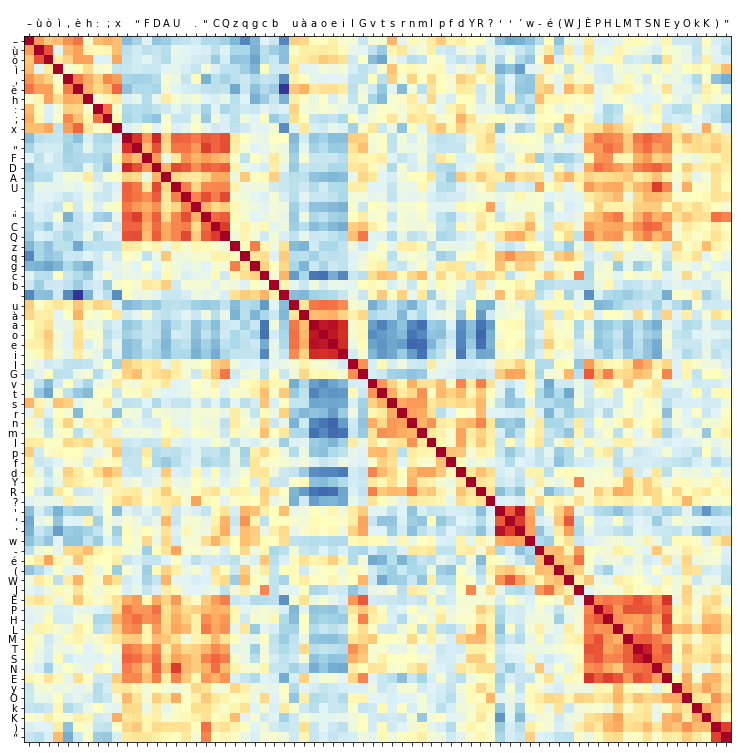

In [171]:
plotDistanceMatrixCluster(clf.coef_, clf.classes_)

In [508]:
from sklearn.preprocessing import StandardScaler

In [172]:
vocabulary = {c:i for i,c in enumerate(set(list(''.join(profile.values()))))}
profileModels = {}
for p in sorted(profile):
    clf = LogisticRegression(random_state=42);
    XX, YY = doc2Matrix(profile[p]+' '.join(vocabulary), vocabulary,3)
    XX = normalize(XX,axis=1, norm='l1');
    clf.fit(XX,YY);
    score = clf.score(XX,YY);
    profileModels[p]={
        'score':score,
        'clf':clf,
        'classes_':''.join(clf.classes_)
    }
    print("Author ",p," - ", score)

Author  candidate00001  -  0.33055469213597444
Author  candidate00002  -  0.30860237828678627
Author  candidate00003  -  0.33116954560457695
Author  candidate00004  -  0.32537348896611124
Author  candidate00005  -  0.3113662528392296


In [173]:
normalize(np.array([[1,2,3],[3,4,2],[5,6,7]]),norm='l1', axis=0)

array([[0.1111, 0.1667, 0.25  ],
       [0.3333, 0.3333, 0.1667],
       [0.5556, 0.5   , 0.5833]])

In [174]:
XX, YY = doc2Matrix(X[30], vocabulary,3);
XX = normalize(XX,axis=1, norm='l1');
#XX = (XX - XX.mean(axis=1,keepdims=True))/XX.std(axis=1, keepdims=True)
#XX = XX/XX.max(axis=1).reshape(-1,1);
print(Y[30])

candidate00005


In [175]:
def distancesProfile(X):
    XX, YY = doc2Matrix(X, vocabulary,3);
    XX = normalize(XX,axis=1, norm='l1');
    probs = np.zeros((len(YY),len(profileModels)));
    for ip,p in enumerate(sorted(profileModels)):
        #print(ip,p)
        pred = profileModels[p]['clf'].predict_proba(XX);
        classes_ = ''.join(profileModels[p]['classes_']);
        for ic,c in enumerate(YY):
            if c in classes_:
                probs[ic,ip] = -np.log(pred[ip,classes_.find(c)]);
            else:
                print(c)
                probs[ic,ip] = 5;
                #probs[ic,ip] = -1.0/len(classes_)
    return np.mean(probs,axis=0)/np.std(probs,axis=0);

In [176]:
distancesProfile(X[0])

array([3.0883, 2.2765, 2.5927, 2.1868, 2.5274])

In [177]:
np.mean(probs,axis=0)/np.std(probs,axis=0)

array([4.6831, 6.3297, 5.2129, 5.2273, 6.9659])

In [178]:
probs = np.zeros((len(X), len(profileModels)))
for i in range(len(X)):
    probs[i,:] = distancesProfile(X[i])

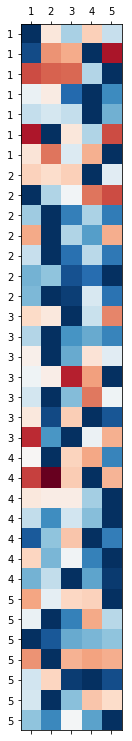

In [179]:
fig, ax = plt.subplots(figsize=(13,13))
ax.matshow(probs/probs.max(axis=1).reshape(-1,1), cmap=plt.cm.RdBu)
plt.yticks(range(len(Y)),[int(i[-1]) for i in Y]);
plt.xticks(range(len(profileModels.keys())),[int(i[-1]) for i in sorted(profileModels.keys())]);
plt.show()

In [180]:
zip(np.argmax(, axis=1), [int(i[-1]) for i in Y])

SyntaxError: invalid syntax (<ipython-input-180-fdb1e6f93f21>, line 1)

In [54]:
for ip,p in enumerate(sorted(profileModels)):
    print(ip,p)
    pred = profileModels[p]['clf'].predict_proba(XX)
    np.log(pred)

0 candidate00001
1 candidate00002
2 candidate00003
3 candidate00004
4 candidate00005


In [55]:
np.round(pred,decimals=3)

array([[0.049, 0.034, 0.   , ..., 0.   , 0.048, 0.   ],
       [0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.064, 0.   , 0.002, ..., 0.   , 0.061, 0.   ],
       [0.065, 0.   , 0.013, ..., 0.   , 0.057, 0.   ],
       [0.07 , 0.07 , 0.   , ..., 0.   , 0.07 , 0.   ]])

In [56]:
np.sum(np.mean(-np.log2(pred),axis=1))

109991.74495023859

In [57]:
-np.log2(probs)

array([[-2.0985, -3.4823, -4.3943, -4.2873, -2.3219],
       [-2.7695, -4.4833, -4.8685, -2.5734, -3.2289],
       [-2.7695, -4.4833, -4.8685, -2.5734, -3.2289],
       ...,
       [-2.7695, -4.4833, -4.8685, -2.5734, -3.2289],
       [-2.7695, -4.4833, -4.8685, -2.5734, -3.2289],
       [-2.0985, -3.4823, -4.3943, -4.2873, -2.3219]])

In [58]:
e=np.mean(-np.log2(probs),axis=0)
e

array([-3.921 , -3.767 , -3.6131, -4.107 , -3.7473])

In [539]:
np.round(np.exp(-e)/np.exp(-e).sum(),decimals=3)

array([0.207, 0.188, 0.187, 0.198, 0.221])